In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, average_precision_score, balanced_accuracy_score



In [2]:
#create our dataframe 
df=pd.read_csv('/Users/vivian/Documents/people_analytics/employee_data.csv')
df.head()

,EmployeeID,Age,Gender,DistanceFromHome,JobLevel,Department,MonthlyIncome,PerformanceRating,JobSatisfaction,Attrition
0,1001,41,Female,1,2,Sales,5993,3,4,Yes
1,1002,49,Male,8,2,Research & Development,5130,4,2,No
2,1004,37,Male,2,1,Research & Development,2090,3,3,Yes
3,1005,33,Female,3,1,Research & Development,2909,3,3,No
4,1007,27,Male,2,1,Research & Development,3468,3,2,No


In [3]:
df_category = df.select_dtypes(include='object')
print (df_category)

      Gender              Department Attrition
0     Female                   Sales       Yes
1       Male  Research & Development        No
2       Male  Research & Development       Yes
3     Female  Research & Development        No
4       Male  Research & Development        No
...      ...                     ...       ...
1465    Male  Research & Development        No
1466    Male  Research & Development        No
1467    Male  Research & Development        No
1468    Male                   Sales        No
1469    Male  Research & Development        No

[1470 rows x 3 columns]


In [4]:
#We need to encode the categorical columns 

# Drop EmployeeID since it's just an identifier
X = df.drop(columns=['EmployeeID', 'Attrition'])
y = df['Attrition']

# Convert target "Attrition" (Yes/No) into numeric
y = y.map({'Yes': 1, 'No': 0})

# One-hot encode categorical columns
X = pd.get_dummies(X, columns=['Gender', 'Department'], drop_first=True)
X = X.astype(int)

print(X.head().T)
print(y.head().T)


                                      0     1     2     3     4
Age                                  41    49    37    33    27
DistanceFromHome                      1     8     2     3     2
JobLevel                              2     2     1     1     1
MonthlyIncome                      5993  5130  2090  2909  3468
PerformanceRating                     3     4     3     3     3
JobSatisfaction                       4     2     3     3     2
Gender_Male                           0     1     1     0     1
Department_Research & Development     0     1     1     1     1
Department_Sales                      1     0     0     0     0
0    1
1    0
2    1
3    0
4    0
Name: Attrition, dtype: int64


In [5]:
attrition_counts = df['Attrition'].value_counts(normalize=True)

([<matplotlib.patches.Wedge at 0x15cc83140>,
 [Text(-0.5336332157899547, -0.961891673217765, 'No Attrition (0)'),
  Text(0.5336332157899549, 0.961891673217765, 'Attrition (1)')],
 [Text(-0.2910726631581571, -0.5246681853915082, '83.9%'),
  Text(0.29107266315815716, 0.5246681853915082, '16.1%')])

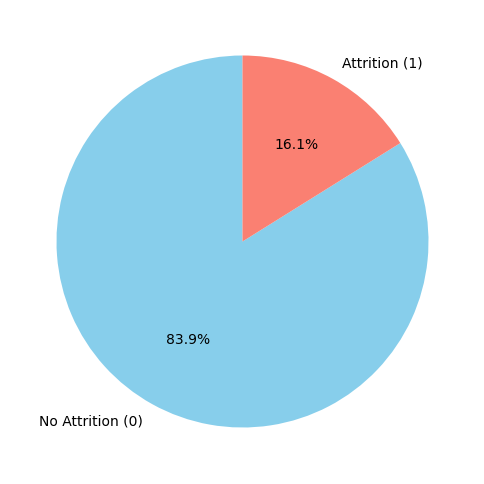

In [6]:
plt.figure(figsize=(6, 8))
plt.pie(attrition_counts, 
        labels=["No Attrition (0)", "Attrition (1)"], 
        autopct="%1.1f%%", 
        startangle=90, 
        colors=["skyblue", "salmon"])

In [7]:
# Since we have done EDA in part1, I will not do entire EDA here. I know I have an imbalanced dataset, so I will fix that problem by using smote before running classification model here.

In [8]:
# We'll split our data into training and testing datasets. 

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, stratify=y, random_state=42)


In [9]:
#Fit scaler on training data, transform train, then SMOTE in scaled space

scaler = StandardScaler(with_mean=False) if hasattr(X, "todense") else StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_scaled, y_train)

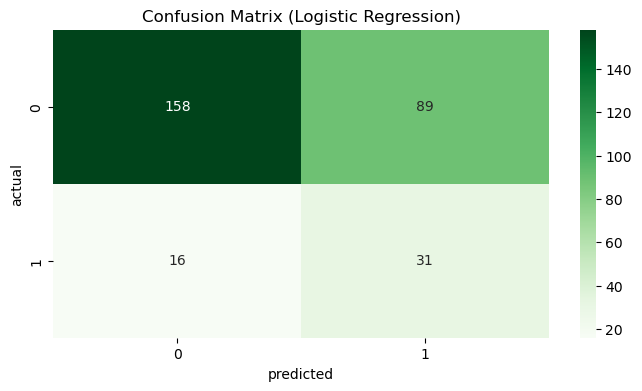

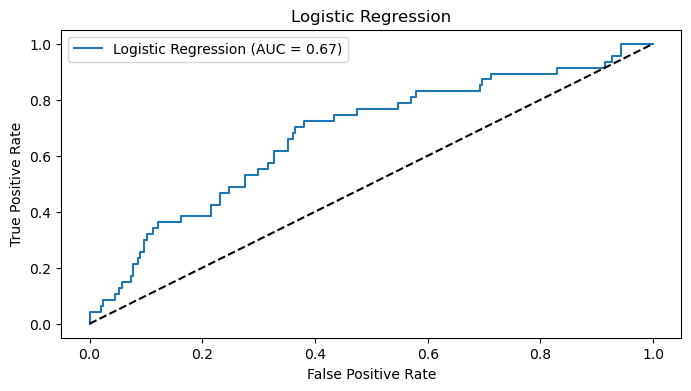

ROC AUC: 0.6740
              precision    recall  f1-score   support

           0       0.91      0.64      0.75       247
           1       0.26      0.66      0.37        47

    accuracy                           0.64       294
   macro avg       0.58      0.65      0.56       294
weighted avg       0.80      0.64      0.69       294



In [10]:
# Fit model on resampled, scaled train
log_model = LogisticRegression(max_iter=8500, solver="saga", fit_intercept=True)
log_model.fit(X_res, y_res)

# Predict on scaled test
y_pred = log_model.predict(X_test_scaled)
y_pred_prob = log_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
confusionMatrix = confusion_matrix(y_test, y_pred)
classReport = classification_report(y_test, y_pred, zero_division=0)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
rocScore = roc_auc_score(y_test, y_pred_prob)
pr_auc = average_precision_score(y_test, y_pred_prob)
bal_acc = balanced_accuracy_score(y_test, y_pred)

logreg_metrics = {
    "confusion_matrix": confusionMatrix,
    "classification_report": classReport,
    "ROC_AUC": rocScore,
    "PR_AUC": pr_auc,
    "Balanced_Accuracy": bal_acc
}

# Confusion Matrix 
plt.figure(figsize=(8,4))
sns.heatmap(confusionMatrix,annot=True,fmt="d",cmap="Greens")
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel("predicted")
plt.ylabel("actual")
plt.show()

# ROC 
plt.figure(figsize=(8,4))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {rocScore:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression')
plt.legend()
plt.show()

print(f"ROC AUC: {rocScore:.4f}")

print(classReport)

In [18]:
# Get coefficients from the trained logistic regression model

coef = log_model.coef_[0]

# Create a DataFrame
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": coef,
})

# Show top 5 churn drivers (positive coefficients)
churn_drivers = feature_importance[feature_importance["Coefficient"] > 0]
churn_drivers = churn_drivers.sort_values("Coefficient", ascending=False)
print(churn_drivers.head(5))


            Feature  Coefficient
8  Department_Sales     0.291788
1  DistanceFromHome     0.185150
6       Gender_Male     0.089883


In [12]:
#Creating a loop to run models and collect score 


def evaluate_model(model, X_train, y_train, X_test, y_test, use_balanced_sample_weight=False):
    """Fits model and returns a metrics dict."""
    if use_balanced_sample_weight:
        sw = compute_sample_weight(class_weight="balanced", y=y_train)
        model.fit(X_train, y_train, sample_weight=sw)
    else:
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    # For ROC/PR, get probabilities if available; otherwise use decision function
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
        # scale decision scores to [0,1] for PR-AUC comparability (optional)
        y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min() + 1e-9)
    else:
        y_score = y_pred  # fallback

    metrics = {
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "classification_report": classification_report(y_test, y_pred, zero_division=0),
        "ROC_AUC": roc_auc_score(y_test, y_score),
        "PR_AUC": average_precision_score(y_test, y_score),
        "Balanced_Accuracy": balanced_accuracy_score(y_test, y_pred)
    }
    return metrics


In [13]:
# Random Forest (use class_weight to help even after SMOTE) 
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=2,
    class_weight="balanced",   
    n_jobs=-1,
    random_state=42
)
rf_metrics = evaluate_model(rf, X_res, y_res, X_test, y_test)

# Balanced Random Forest (imblearn) ---

brf = BalancedRandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    sampling_strategy="auto",
    n_jobs=-1,
    random_state=42
)
brf_metrics = evaluate_model(brf, X_res, y_res, X_test, y_test)

# HistGradientBoosting: HGB doesn't take class_weight in all versions; pass balanced sample_weight instead
hgb = HistGradientBoostingClassifier(
    learning_rate=0.06,
    max_depth=None,
    max_iter=400,
    l2_regularization=1.0,
    random_state=42
)
hgb_metrics = evaluate_model(hgb, X_res, y_res, X_test, y_test)



/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  w

In [14]:
# Collect all results in a list/dict to compare to your Logistic Regression baseline

all_results = {
    "LogReg (baseline)": logreg_metrics,        
    "RandomForest": rf_metrics,
    "BalancedRandomForest": brf_metrics,
    "HistGradientBoosting": hgb_metrics
}

#sort by ROC_AUC descending
sorted_items = sorted(all_results.items(), key=lambda kv: kv[1].get("ROC_AUC", float("-inf")), reverse=True)

def fmt(x): 
    return "NA" if x is None else f"{x:.3f}"

for name, m in sorted_items:
    print(
        f"{name:25s}  "
        f"ROC-AUC={fmt(m.get('ROC_AUC'))}  "
        f"PR-AUC={fmt(m.get('PR_AUC'))}  "
        f"BalAcc={fmt(m.get('Balanced_Accuracy'))}"
    )


LogReg (baseline)          ROC-AUC=0.674  PR-AUC=0.305  BalAcc=0.650
BalancedRandomForest       ROC-AUC=0.621  PR-AUC=0.225  BalAcc=0.561
RandomForest               ROC-AUC=0.610  PR-AUC=0.226  BalAcc=0.561
HistGradientBoosting       ROC-AUC=0.479  PR-AUC=0.181  BalAcc=0.565


<Figure size 1000x600 with 0 Axes>

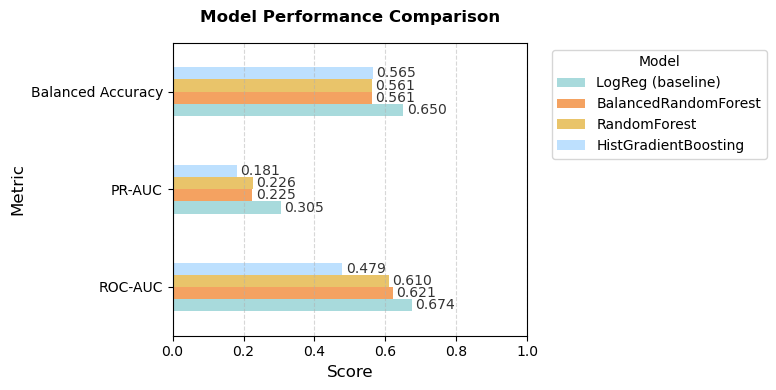

In [15]:
#Create data viz for model comparison 

data = {
    "Model": ["LogReg (baseline)", "BalancedRandomForest", "RandomForest", "HistGradientBoosting"],
    "ROC-AUC": [0.674, 0.621, 0.610, 0.479],
    "PR-AUC": [0.305, 0.225, 0.226, 0.181],
    "Balanced Accuracy": [0.650, 0.561, 0.561, 0.565]
}

df = pd.DataFrame(data)
df.set_index("Model", inplace=True)


plt.figure(figsize=(10, 6))
colors = ["#A8DADC", "#F4A261", "#E9C46A","#BDE0FE"]  
df_t = df.T

# Plot
ax = df_t.plot(kind="barh", figsize=(8, 4), color=colors, width=0.5)


for i, bars in enumerate(ax.containers):
    # Loop through each bar in the group
    for bar in bars:
        width = bar.get_width()
        ax.text(
            width + 0.01,                 
            bar.get_y() + bar.get_height() / 2,
            f"{width:.3f}",             
            va="center", ha="left", fontsize=10, color="#333333"
        )

plt.title("Model Performance Comparison", fontsize=12, fontweight="bold", pad=15)
plt.xlabel("Score", fontsize=12)
plt.ylabel("Metric", fontsize=12)
plt.xlim(0, 1)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()

plt.show()
